In [1]:
from numpy.random import shuffle
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
# load dataset

import sqlite3
import pandas as pd
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM conv_10_lin_3_epoch_50', conn)

df.sort_values(by='val_acc', ascending=False, inplace=True)
df['seq'] = df['hex_str'].apply(str_to_vec)
df.seq.apply(len).value_counts()

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seq
11    97
12    94
10    92
13    85
9     79
15    75
14    66
8     62
16    55
6     40
17    38
18    37
7     33
19    29
5     24
20    17
21    17
22    15
4     14
24    11
23     6
27     4
25     3
26     2
29     2
28     2
33     1
Name: count, dtype: int64

In [3]:
df.seq.sample().item().shape

(10, 32)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.nn.functional as F

# Dataset definition remains the same
class SequenceDataset(Dataset):
    """
    Simple dataset, loads sequences to GPU as list tensors
    """
    def __init__(self, sequences, targets):
        """        
        Args:
            sequences (list): list of 1D arrays
            targets: 1D array of target values
        """
        self.sequences = [torch.tensor(seq).type(torch.cuda.FloatTensor) for seq in sequences]
        self.targets = torch.tensor(targets).view(-1, 1).type(torch.cuda.FloatTensor)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        return sequence, target

In [5]:
df.seq.apply(len).value_counts()

seq
11    97
12    94
10    92
13    85
9     79
15    75
14    66
8     62
16    55
6     40
17    38
18    37
7     33
19    29
5     24
20    17
21    17
22    15
4     14
24    11
23     6
27     4
25     3
26     2
29     2
28     2
33     1
Name: count, dtype: int64

In [6]:
dataset = SequenceDataset(df.seq.tolist(), df.val_acc)

In [7]:
import random
idx = random.choice(range(len(dataset)))
dataset[idx]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.

In [8]:
# if batch_size == 1: simple random sampler
# if batch_size > 1:
#   oversample dataset for each seq bin so, len(seq) % batch_size = 0 
#   random sample of batches from each seq len bin

In [9]:
class SimpleLoader:
    """ Simple data loader 
    """    
    def __init__(self, dataset = None, batch_size = 1, sampler = None):
        self.dataset = dataset
        # self.batch_size = batch_size
        # self.sampler = sampler
        self._idx = 0
    
    def __iter__(self):
        self._idx = 0
        return self

    def __next__(self):
        if self._idx >= len(self.dataset):
            raise StopIteration
        
        x = self.dataset[self._idx][0].unsqueeze(0)
        y = self.dataset[self._idx][1].unsqueeze(0)
        self._idx += 1
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [10]:
class SimpleYieldLoader:
    """ Simple data loader 
    """    
    def __init__(self, dataset = None, batch_size = 1, sampler = None):
        self.dataset = dataset
        # self.batch_size = batch_size
        # self.sampler = sampler
        self._idx = 0
    
    def __iter__(self):
        for i in range(len(self.dataset)):
            yield self.dataset[i][0].unsqueeze(0), self.dataset[i][1].unsqueeze(0)
    
    def __len__(self):
        return len(self.dataset)

In [11]:
# Test with your custom DataLoader (assuming SimpleLoader or DataLoader)
batch_size = 2
# loader = SimpleLoader(dataset, batch_size=batch_size)
loader = SimpleYieldLoader(dataset, batch_size=batch_size)

# Iterate through the loader and print the batches
for i, (x_batch, y_batch) in enumerate(loader):
    print(f"Batch {i + 1}:")
    x_batch = x_batch.cpu().numpy()
    y_batch = y_batch.cpu().numpy()
    print("X batch:", x_batch, x_batch.shape)
    print("Y batch:", y_batch, y_batch.shape)    

Batch 1:
X batch: [[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
   0. 0. 0. 1. 0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   1. 0. 0. 1. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
   0. 0. 1. 0. 1. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0

In [12]:
import numpy as np
batch_size = 4
sequences = [x[0].cpu().numpy() for x in dataset]
sequences[4].shape

(7, 32)

<Axes: >

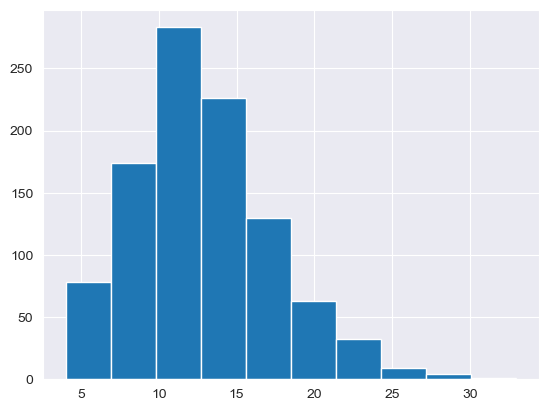

In [13]:
ser = pd.Series(sequences, name='len')
seq_len = ser.apply(len)
seq_len.hist()

In [14]:
seq_len

0      19
1      33
2      21
3      16
4       7
       ..
995    20
996    12
997    24
998    12
999     9
Name: len, Length: 1000, dtype: int64

In [15]:
df = pd.DataFrame([sequences]).T.rename(columns={0:'seq'})
df['len'] = df.seq.apply(len)

In [16]:
df.reset_index().groupby('len')['index'].apply(list).to_dict()

{4: [15, 33, 48, 66, 84, 95, 168, 178, 432, 485, 534, 892, 935, 943],
 5: [77,
  88,
  129,
  134,
  246,
  259,
  328,
  436,
  470,
  578,
  680,
  683,
  769,
  798,
  906,
  910,
  912,
  920,
  924,
  957,
  962,
  976,
  978,
  983],
 6: [27,
  181,
  257,
  288,
  322,
  327,
  332,
  346,
  364,
  373,
  385,
  392,
  521,
  559,
  603,
  609,
  627,
  637,
  643,
  652,
  672,
  682,
  701,
  755,
  759,
  780,
  822,
  838,
  841,
  862,
  865,
  876,
  878,
  883,
  900,
  901,
  909,
  923,
  948,
  965],
 7: [4,
  65,
  100,
  266,
  286,
  324,
  424,
  476,
  507,
  530,
  576,
  581,
  624,
  642,
  656,
  681,
  684,
  731,
  756,
  782,
  784,
  788,
  806,
  824,
  858,
  866,
  881,
  890,
  921,
  951,
  972,
  979,
  987],
 8: [9,
  11,
  40,
  42,
  60,
  70,
  73,
  90,
  91,
  106,
  118,
  165,
  187,
  196,
  202,
  212,
  218,
  244,
  267,
  289,
  296,
  310,
  354,
  356,
  359,
  366,
  375,
  403,
  438,
  441,
  462,
  465,
  489,
  553,
  579,
  588,


In [17]:
df.reset_index()['len'].to_dict()

{0: 19,
 1: 33,
 2: 21,
 3: 16,
 4: 7,
 5: 9,
 6: 13,
 7: 12,
 8: 15,
 9: 8,
 10: 10,
 11: 8,
 12: 10,
 13: 26,
 14: 9,
 15: 4,
 16: 24,
 17: 10,
 18: 13,
 19: 9,
 20: 19,
 21: 12,
 22: 18,
 23: 18,
 24: 12,
 25: 12,
 26: 11,
 27: 6,
 28: 16,
 29: 14,
 30: 13,
 31: 18,
 32: 13,
 33: 4,
 34: 24,
 35: 17,
 36: 14,
 37: 15,
 38: 27,
 39: 9,
 40: 8,
 41: 13,
 42: 8,
 43: 17,
 44: 13,
 45: 10,
 46: 23,
 47: 14,
 48: 4,
 49: 16,
 50: 11,
 51: 16,
 52: 17,
 53: 13,
 54: 11,
 55: 25,
 56: 18,
 57: 16,
 58: 21,
 59: 19,
 60: 8,
 61: 13,
 62: 11,
 63: 9,
 64: 14,
 65: 7,
 66: 4,
 67: 16,
 68: 10,
 69: 10,
 70: 8,
 71: 12,
 72: 17,
 73: 8,
 74: 18,
 75: 20,
 76: 10,
 77: 5,
 78: 18,
 79: 15,
 80: 15,
 81: 14,
 82: 13,
 83: 11,
 84: 4,
 85: 12,
 86: 13,
 87: 15,
 88: 5,
 89: 16,
 90: 8,
 91: 8,
 92: 21,
 93: 10,
 94: 9,
 95: 4,
 96: 13,
 97: 15,
 98: 16,
 99: 27,
 100: 7,
 101: 9,
 102: 18,
 103: 21,
 104: 13,
 105: 23,
 106: 8,
 107: 11,
 108: 22,
 109: 11,
 110: 9,
 111: 10,
 112: 14,
 113: 18,


In [18]:
# random choice of idx
idx = np.random.choice(len(df))
idx

704

In [19]:
# seq len
seq = df.loc[idx, 'seq']
seq_len = df.loc[idx, 'len']
seq_len

15

In [20]:
# get ids of all sequences of that len
ids = df.index[df.len == seq_len].tolist()
len(ids), len(ids) % batch_size

(75, 3)

In [21]:
ids

[8,
 37,
 79,
 80,
 87,
 97,
 136,
 140,
 173,
 177,
 182,
 198,
 200,
 209,
 226,
 242,
 271,
 274,
 277,
 282,
 308,
 326,
 340,
 347,
 350,
 360,
 376,
 386,
 412,
 430,
 434,
 443,
 457,
 478,
 481,
 488,
 535,
 564,
 580,
 590,
 606,
 616,
 623,
 635,
 648,
 662,
 669,
 679,
 698,
 702,
 704,
 710,
 714,
 722,
 733,
 735,
 736,
 761,
 804,
 836,
 845,
 851,
 856,
 857,
 867,
 868,
 926,
 927,
 945,
 950,
 974,
 977,
 990,
 992,
 994]

In [22]:
np.random.shuffle(ids)
ids

[856,
 704,
 735,
 274,
 376,
 990,
 79,
 488,
 698,
 535,
 80,
 434,
 326,
 87,
 868,
 590,
 340,
 277,
 481,
 8,
 271,
 580,
 679,
 140,
 635,
 350,
 182,
 926,
 173,
 851,
 242,
 992,
 226,
 714,
 198,
 662,
 200,
 478,
 761,
 37,
 347,
 733,
 97,
 974,
 606,
 136,
 412,
 945,
 669,
 845,
 308,
 836,
 282,
 443,
 927,
 648,
 457,
 977,
 209,
 867,
 994,
 736,
 710,
 430,
 804,
 177,
 616,
 857,
 950,
 386,
 722,
 702,
 623,
 360,
 564]

In [124]:
from copy import deepcopy
import numpy as np

class SequenceLoader:
    """ Simple data loader 
    """    
    def __init__(self, dataset = None, batch_size = 1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.len_dict, self.rev_len_dict = self._get_len_dicts()
        self._rev_len_dict = deepcopy(self.rev_len_dict)
        self._idx = 0
        print(self.len_dict)
        print(self.rev_len_dict)
    
    def _get_len_dicts(self):
        sequences = [x[0].cpu().numpy() for x in self.dataset]
        df = pd.DataFrame([sequences]).T.rename(columns={0:'seq'})
        df['len'] = df.seq.apply(len)
        
        len_dict = df.reset_index()['len'].to_dict()  # idx -> len
        rev_len_dict = df.reset_index().groupby('len')['index'].apply(list).to_dict()  # len -> ids list        
        
        # shuffle ids list
        for v in rev_len_dict.values():
            np.random.shuffle(v)
            
        return len_dict, rev_len_dict
    
    def __iter__(self):
        while len([i for v in self.rev_len_dict.values() for i in v]) > 0:
            ids_list = [i for v in self.rev_len_dict.values() for i in v]
            i = np.random.choice(ids_list)
            batch_ids = []
            seq_len = self.len_dict[i]
            
            for j in range(self.batch_size):                
                # try pop until ids list not empty
                if len(self.rev_len_dict[seq_len]) != 0:
                    batch_ids.append(self.rev_len_dict[seq_len].pop())
                else:
                    # oversampling from full list
                    batch_ids.append(np.random.choice(self._rev_len_dict[seq_len]))
                
            print(f"Batch idx {i}:", batch_ids)
            batch_ids = torch.tensor(batch_ids).type(torch.cuda.IntTensor)            
            X = torch.stack([self.dataset[i][0] for i in batch_ids])
            y = torch.stack([self.dataset[i][1] for i in batch_ids])
            yield X, y                        
    
    def __len__(self):
        return len(self.dataset)

In [54]:
sequences = [x[0].cpu().numpy() for x in dataset]

In [55]:
batch_ids = [200, 209]
torch.stack([dataset[i][0] for i in batch_ids])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
          1., 0., 0., 1., 0.

In [56]:
torch.stack([dataset[i][1] for i in batch_ids]).shape

torch.Size([2, 1])

In [105]:
loader = SequenceLoader(dataset, batch_size=8)

next(iter(loader))[0].shape, next(iter(loader))[1].shape

(torch.Size([8, 10, 32]), torch.Size([8, 1]))

In [125]:
import torch
from torch.utils.data import random_split
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

train, val = random_split(dataset, [0.95, 0.05], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [122]:
sequences = [x[0].cpu().numpy() for x in val]
df = pd.DataFrame([sequences]).T.rename(columns={0:'seq'})
df['len'] = df.seq.apply(len)

len_dict = df.reset_index()['len'].to_dict()  # idx -> len
rev_len_dict = df.reset_index().groupby('len')['index'].apply(list).to_dict()  # len -> ids list  
df

,seq,len
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",10
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",7
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [123]:
val[21][0].shape, val[22][0].shape, 

(torch.Size([13, 32]), torch.Size([13, 32]))

In [128]:
loader = SequenceLoader(val, batch_size=2)

next(iter(loader))[0].shape, next(iter(loader))[1].shape

{0: 10, 1: 7, 2: 8, 3: 13, 4: 15, 5: 15, 6: 15, 7: 9, 8: 14, 9: 8, 10: 29, 11: 21, 12: 16, 13: 5, 14: 12, 15: 8, 16: 9, 17: 10, 18: 19, 19: 15, 20: 19, 21: 13, 22: 13, 23: 8, 24: 14, 25: 9, 26: 16, 27: 6, 28: 8, 29: 10, 30: 15, 31: 12, 32: 18, 33: 17, 34: 17, 35: 9, 36: 17, 37: 11, 38: 17, 39: 15, 40: 18, 41: 13, 42: 9, 43: 21, 44: 11, 45: 10, 46: 13, 47: 12, 48: 13, 49: 10}
{5: [13], 6: [27], 7: [1], 8: [15, 23, 2, 28, 9], 9: [35, 7, 42, 25, 16], 10: [29, 17, 49, 45, 0], 11: [37, 44], 12: [31, 14, 47], 13: [22, 48, 46, 3, 41, 21], 14: [24, 8], 15: [4, 30, 5, 19, 6, 39], 16: [26, 12], 17: [36, 34, 33, 38], 18: [32, 40], 19: [18, 20], 21: [43, 11], 29: [10]}
Batch idx 46: [21, 41]
Batch idx 2: [9, 28]


(torch.Size([2, 13, 32]), torch.Size([2, 1]))

In [99]:
train[8][0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 

In [58]:
loader = SequenceLoader(dataset, batch_size=8)

for i, (x_batch, y_batch) in enumerate(loader):
    pass
    print('x', x_batch.shape)
    print('y', y_batch.shape)

x torch.Size([8, 10, 32])
y torch.Size([8, 1])
x torch.Size([8, 10, 32])
y torch.Size([8, 1])
x torch.Size([8, 26, 32])
y torch.Size([8, 1])
x torch.Size([8, 22, 32])
y torch.Size([8, 1])
x torch.Size([8, 8, 32])
y torch.Size([8, 1])
x torch.Size([8, 12, 32])
y torch.Size([8, 1])
x torch.Size([8, 17, 32])
y torch.Size([8, 1])
x torch.Size([8, 17, 32])
y torch.Size([8, 1])
x torch.Size([8, 9, 32])
y torch.Size([8, 1])
x torch.Size([8, 7, 32])
y torch.Size([8, 1])
x torch.Size([8, 12, 32])
y torch.Size([8, 1])
x torch.Size([8, 15, 32])
y torch.Size([8, 1])
x torch.Size([8, 18, 32])
y torch.Size([8, 1])
x torch.Size([8, 10, 32])
y torch.Size([8, 1])
x torch.Size([8, 11, 32])
y torch.Size([8, 1])
x torch.Size([8, 13, 32])
y torch.Size([8, 1])
x torch.Size([8, 15, 32])
y torch.Size([8, 1])
x torch.Size([8, 13, 32])
y torch.Size([8, 1])
x torch.Size([8, 17, 32])
y torch.Size([8, 1])
x torch.Size([8, 11, 32])
y torch.Size([8, 1])
x torch.Size([8, 14, 32])
y torch.Size([8, 1])
x torch.Size([8,

In [52]:
i

137

In [ ]:
class DataLoaderGPU():
    """ Simple data loader from GPU. 
    Arguments:
        dataset_gpu (dataset): dataset loaded to GPU
        batch_size (int, optional): how many samples per batch to load (default: 1)
        sampler (Sampler): defines strategy to draw samples from dataset
    """    
    def __init__(self, dataset_gpu = None, batch_size = 1, sampler = None):
        self.dataset = dataset_gpu
        self.batch_size = batch_size
        self.sampler = sampler
    
    def __iter__(self):
        self._sampler_iter = iter(self.sampler)
        return self

    def __next__(self):
        index = self._next_index()  # will raise StopIteration
        data = self._next_data(index)
        return data

    def _next_index(self):
        index = []
        for _ in range(self.batch_size):
            index.append(next(self._sampler_iter))
        return torch.tensor(index).type(torch.cuda.IntTensor)  # pylint: disable=not-callable
    
    def _next_data(self, index):
        x = torch.index_select(self.dataset[0], 0, index)
        y = torch.index_select(self.dataset[1], 0, index)
        data = (x, y)
        return data

    def __len__(self):
        return len(self.sampler)
    

class ChunkSampler(Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples (int): # of desired datapoints
        start (int, optional): offset where we should start selecting from (default: 0)
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples